In [16]:
import rasterio
import importlib
import matplotlib.pyplot as plt
from simvp import SimVP
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch
import datetime
from skimage.metrics import structural_similarity as ssim
from datetime import datetime, timedelta

In [17]:
import torch.nn as nn
print(torch.__version__)
print(torch.version.cuda)


2.3.0
12.1


In [18]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU


True
NVIDIA GeForce RTX 4060 Laptop GPU


In [19]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import torch
x = torch.rand(10, 10, device='cuda')
y = torch.rand(10, 10, device='cuda')
z = x + y  # Test simple operation again
print(z)


tensor([[0.8182, 0.5837, 1.0352, 1.3621, 1.0377, 1.2745, 0.9625, 0.8449, 1.2296,
         0.1532],
        [1.2409, 1.1214, 1.1109, 0.9903, 1.0751, 0.1637, 0.3826, 1.6174, 1.4869,
         1.5581],
        [0.9923, 1.4262, 0.6093, 0.6589, 0.8427, 1.4393, 1.1405, 0.6413, 0.7230,
         0.4210],
        [1.3777, 0.7660, 1.1803, 1.0823, 1.4397, 1.4148, 1.0453, 1.2323, 1.3038,
         0.9156],
        [1.0528, 1.2088, 0.8075, 1.6184, 1.5273, 1.1033, 1.1851, 1.1573, 0.7731,
         0.5257],
        [0.9249, 0.4569, 0.5651, 1.6832, 0.4065, 0.5854, 0.5537, 0.7229, 1.7346,
         0.2787],
        [0.1405, 0.0984, 1.0388, 0.8719, 1.2832, 1.6230, 0.5016, 0.6923, 1.0822,
         0.6140],
        [0.2946, 1.4349, 0.6794, 1.4063, 1.4510, 1.1372, 0.4216, 1.7713, 1.0566,
         1.0389],
        [1.0818, 0.2491, 0.7369, 0.4871, 1.0153, 0.8820, 1.5365, 1.5547, 1.5357,
         1.0264],
        [0.9133, 0.7283, 1.0778, 1.1367, 1.1603, 1.1620, 1.4665, 1.5827, 1.3181,
         0.8567]], device='c

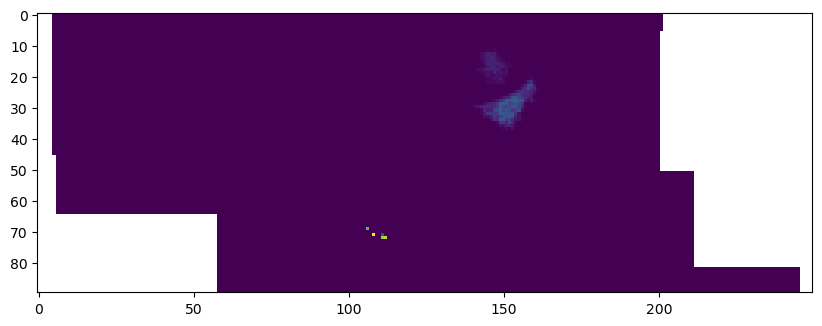

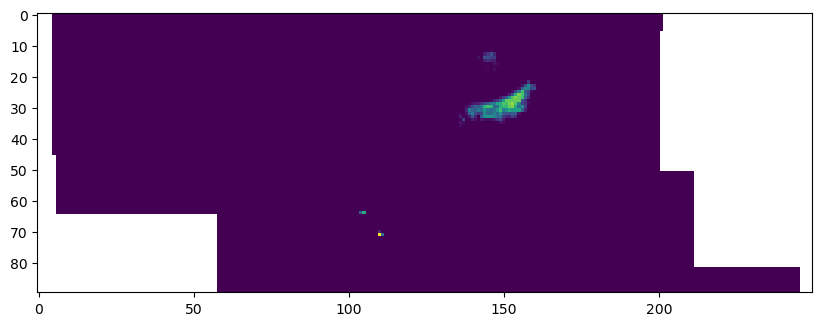

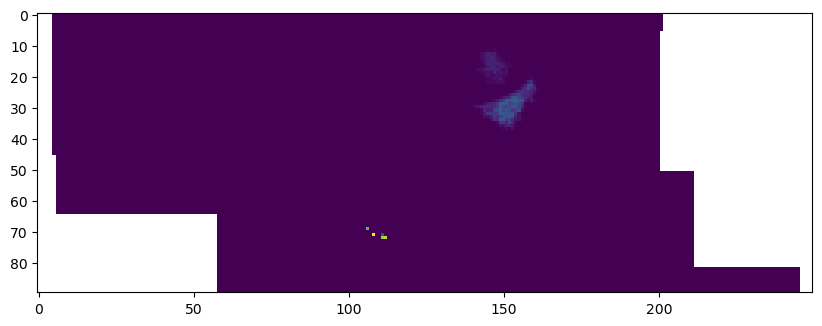

In [20]:
# root_dir = r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001000000.tif'
# root_dir2 = r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001010000.tif'
# root_dir3 = r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001020000.tif'
# img = rasterio.open(root_dir)
# data = img.read(1)  # Read the only band
# plt.figure(figsize=(10, 10))
# plt.imshow(data)
# img2 = rasterio.open(root_dir2)
# data2 = img2.read(1)  # Read the only band
# plt.figure(figsize=(10, 10))
# plt.imshow(data2)
# img3 = rasterio.open(root_dir3)
# data3 = img.read(1)  # Read the only band
# plt.figure(figsize=(10, 10))
# plt.imshow(data3)

root_dir = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001000000.tif'
root_dir2 = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001010000.tif'
root_dir3 = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001020000.tif'
img = rasterio.open(root_dir)
data = img.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data)
img2 = rasterio.open(root_dir2)
data2 = img2.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data2)
img3 = rasterio.open(root_dir3)
data3 = img.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data3)

In [21]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def hook(module, input, output):
    if torch.isnan(output).any():
        print(f"NaNs in {module}")

# Cell 2: Helper Functions
def clean_data(data):
    data[np.isinf(data)] = np.finfo(np.float32).max
    data[np.isnan(data)] = 0
    return data

def inspect_raw_data(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(np.float32)
        has_nans = np.isnan(data).any()
        has_infs = np.isinf(data).any()
        print(f"File: {file_path} - Contains NaNs: {has_nans}, Contains Infs: {has_infs}")


In [22]:
import numpy as np
import torch
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import rasterio
from calendar import monthrange

def print_stats(data, name):
    # Check if data contains any infinite or NaN values and provide statistics
    finite_data = np.isfinite(data)
    if finite_data.all():
        print(f'{name} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}')
    else:
        finite_only = data[finite_data]  # Filter out non-finite values for stats
        print(f'{name} contains non-finite values: Min: {finite_only.min()}, Max: {finite_only.max()}, Mean: {finite_only.mean()}, Std: {finite_only.std()}')

def clean_data(data):
    """Replace inf and NaN values with the mean of finite values in the array."""
    if not np.isfinite(data).all():
        finite_mean = np.nanmean(data[np.isfinite(data)])  # Mean of finite values
        data = np.nan_to_num(data, nan=finite_mean, posinf=finite_mean, neginf=finite_mean)
    return data

class RadarTIFFDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.transform = transforms.Compose([
            transforms.Lambda(lambda x: clean_data(x)),  # Clean data before any other transformation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_paths) - 2  # Ensure we have enough files for a sequence

    def __getitem__(self, idx):
        with rasterio.open(self.file_paths[idx]) as img1:
            x1 = img1.read(1).astype(np.float32)
            print_stats(x1, "Before transformation X1")
            x1 = self.transform(x1)

        with rasterio.open(self.file_paths[idx + 1]) as img2:
            x2 = img2.read(1).astype(np.float32)
            x2 = self.transform(x2)

        with rasterio.open(self.file_paths[idx + 2]) as img3:
            y = img3.read(1).astype(np.float32)
            y = self.transform(y)

        x = torch.stack([x1, x2], dim=0)
        return x, y

def get_radar_file_paths(year, month, day_range, base_path):
    all_files = []
    base_dir = Path(base_path)
    month_dir = base_dir / str(year) / f"{month:02d}"
    # Adjust day range based on the month and year
    start_day, end_day = day_range.get(year, {}).get(month, (1, monthrange(year, month)[1]))
    for day in range(start_day, end_day + 1):
        day_dir = month_dir / f"{day:02d}"
        if day_dir.exists():  # Check if the directory exists
            tif_files = list(day_dir.glob("*.tif"))
            # Replace backslashes and convert to strings
            tif_files = [str(p).replace("\\", "/") for p in tif_files]
            all_files.extend(tif_files)
    return all_files

# Setup the dictionary for specific day ranges in each month and year
base_path =  r'..\DATA_SV\Precipitation\Radar'

train_day_range = {
    2019: {4: (1, 15), 10: (1, 15)},  # All days in April and October 2019
    2020: {4: (1, 15), 10:(0, 0)}  # Days 1 to 15 in April 2020
}

train_years = [2019, 2020]
train_months = [4, 10]

validation_day_range = {
    2020: {4: (16, 30)}  # Days 16 to 30 in April 2020
    # 2020: {4: (16, 16)}  # Days 16 to 30 in April 2020
}
validation_years = [2020]
validation_months = [4]

test_day_range = {
    2020: {10: (1, 31)},  # All days in October 2020
}
test_years = [2020]
test_months = [10]
# Example usage
# years = [2019]  
# months = [4, 10]

# all_file_paths = []

train_set = []
validation_set = []
test_set = []

for year in train_years:
    for month in train_months:
        train_set.extend(get_radar_file_paths(year, month, train_day_range, base_path))
    
for year in validation_years:
    for month in validation_months:
        validation_set.extend(get_radar_file_paths(year, month, validation_day_range, base_path))

for year in test_years:
    for month in test_months:
        test_set.extend(get_radar_file_paths(year, month, test_day_range, base_path))

# print(all_file_paths)
print(train_set)

train_dataset = RadarTIFFDataset(train_set)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

validation_dataset = RadarTIFFDataset(validation_set)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

# for x, y in dataloader:
#     print("Input shape:", x.shape)  
#     print("Output shape:", y.shape) 


['../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401000000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401010000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401020000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401030000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401040000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401050000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401060000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401070000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401080000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401090000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401100000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401110000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401120000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401130000.tif', '../DATA_SV/Precipi

In [23]:
from torch.optim import Adam
import time

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Change based on your activation
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Adjust accordingly
        if m.bias is not None:
            nn.init.zeros_(m.bias)
def check_nan_inf(data, name="Data"):
    if torch.isnan(data).any():
        print(f'{name} contains NaNs')
    if torch.isinf(data).any():
        print(f'{name} contains Infs')

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y_true)
            total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss

save_dir = '../simvp//pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimVP(shape_in=(2, 3, 128, 128)).to(device)
model.apply(init_weights)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
# num_epochs = 1


# def train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir):
#     start_epoch = 0
#     checkpoint_path = os.path.join(save_dir, 'last_checkpoint.pth')
    
#     # Load checkpoint if exists
#     if os.path.exists(checkpoint_path):
#         checkpoint = torch.load(checkpoint_path)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#         start_epoch = checkpoint['epoch'] + 1
#         print(f"Loaded checkpoint from epoch {start_epoch}")
    
#     for epoch in range(start_epoch, num_epochs):
#         start_time = time.time()
#         model.train()
#         total_train_loss = 0
#         for x, y_true in train_loader:
#             x, y_true = x.to(device), y_true.to(device)
#             optimizer.zero_grad()
#             y_pred = model(x)
#             loss = criterion(y_pred, y_true)
#             loss.backward()
#             optimizer.step()
#             scheduler.step()
#             total_train_loss += loss.item()

#         epoch_time = time.time() - start_time
#         average_train_loss = total_train_loss / len(train_loader)
#         validation_loss = validate(model, validation_loader, criterion, device)
        
#         print(f'Epoch {epoch+1}, Train Loss: {average_train_loss:.4f}, Validation Loss: {validation_loss:.4f}')
        
#         # Save the model and optimizer state
#         checkpoint = {
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_state_dict': scheduler.state_dict()
#         }
#         torch.save(checkpoint, checkpoint_path)
#         print(f'Model and optimizer state saved for epoch {epoch+1} at {checkpoint_path}')


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
# model.apply(init_weights)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs=30, device=device, save_dir = '../simvp//pth')

In [24]:
# Load the checkpoint
checkpoint = torch.load('D:\\Workspace\\Projects\\qpn-simvp\\simvp\\pth\\last_checkpoint.pth')
print(checkpoint.keys())
# Assume the model's state dictionary is stored under 'model_state_dict'
model.load_state_dict(checkpoint['model_state_dict'])
model_dict = model.state_dict()
# 1. Filter out unnecessary keys
pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k in model_dict and model_dict[k].size() == v.size()}
# 2. Overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. Load the new state dict
model.load_state_dict(model_dict)


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict'])


<All keys matched successfully>

In [25]:
# Helper function to extract date and time from filename
def extract_datetime_from_filename(filename):
    # Extract the timestamp part from the filename
    timestamp_str = filename.split('_')[-1].split('.')[0]
    # Convert to datetime object
    timestamp = datetime.datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    return timestamp

# Define function to predict next timestamp
def predict_next_datetime(current_datetime, time_step_minutes=120):
    return current_datetime + datetime.timedelta(minutes=time_step_minutes)

def print_stats(data, name):
    finite_data = np.isfinite(data)
    if finite_data.all():
        print(f'{name} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}')
    else:
        finite_vals = data[finite_data]
        print(f'{name} contains non-finite values. Finite stats - Min: {finite_vals.min()}, Max: {finite_vals.max()}, Mean: {finite_vals.mean()}, Std: {finite_vals.std()}')

def clean_data(data):
    finite_vals = np.isfinite(data)
    if not finite_vals.all():
        min_val = np.min(data[finite_vals]) if np.any(finite_vals) else 0
        max_val = np.max(data[finite_vals]) if np.any(finite_vals) else 1
        data = np.clip(data, min_val, max_val)
        data[~finite_vals] = np.mean(data[finite_vals])  # Replace non-finite values with the mean of finite ones
    return data

def extract_datetime_from_filename(file_path):
    filename = file_path.split('\\')[-1]
    datetime_str = filename.split('_')[1].split('.')[0]
    return datetime.strptime(datetime_str, "%Y%m%d%H%M%S")

def predict_next_datetime(current_datetime):
    return current_datetime + timedelta(hours=1)

def compute_metrics(prediction, ground_truth):
    mse = np.mean((prediction - ground_truth) ** 2)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    ssim_index = ssim(prediction, ground_truth, data_range=ground_truth.max() - ground_truth.min())
    return mse, psnr, ssim_index

torch.Size([1, 2, 1, 90, 250])
Non-finite values detected in predictions.
Prediction is clean.


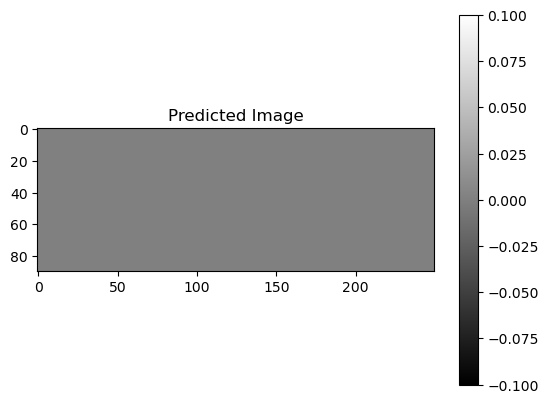

Current datetime from input file: 2020-10-01 00:00:00
Predicted datetime for next frame: 2020-10-01 01:00:00


In [26]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import rasterio

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_file_path = 'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\Radar\\2020\\10\\01\\Radar_20201001000000.tif'

with rasterio.open(input_file_path) as src:
    input_data = src.read(1)

input_data = input_data.astype(np.float32)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformation
input_tensor = transform(input_data)
input_tensor = torch.stack([input_tensor, input_tensor], dim=0) 
input_tensor = input_tensor.unsqueeze(0).to(device) 

# Load the model
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
checkpoint_path = 'D:\\Workspace\\Projects\\qpn-simvp\\simvp\\pth\\last_checkpoint.pth'
checkpoint = torch.load(checkpoint_path)

if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)  # If the checkpoint is just a state dict

model.eval()

# Predict and visualize
with torch.no_grad():
    prediction = model(input_tensor)

# Checking for non-finite values in predictions
finite_mask = torch.isfinite(prediction)
if not finite_mask.all():
    print("Non-finite values detected in predictions.")
    prediction[~finite_mask] = 0  # Replace non-finite values with zero or some appropriate value

predicted_image = prediction.squeeze().cpu().numpy()
if np.isfinite(predicted_image).all():
    print("Prediction is clean.")
    plt.imshow(predicted_image[0], cmap='gray')  
    plt.colorbar()
    plt.title("Predicted Image")
    plt.show()
else:
    print("Still contains non-finite values after correction.")

def extract_datetime_from_filename(file_path: str) -> datetime.datetime:
    filename = file_path.split('\\')[-1]
    datetime_str = filename.split('_')[1].split('.')[0]
    return datetime.datetime.strptime(datetime_str, "%Y%m%d%H%M%S")

def predict_next_datetime(current_datetime: datetime.datetime) -> datetime.datetime:
    # Assuming the next frame is 1 hour ahead
    return current_datetime + datetime.timedelta(hours=1)

current_datetime = extract_datetime_from_filename(input_file_path)
print("Current datetime from input file:", current_datetime)

predicted_datetime = predict_next_datetime(current_datetime)
print("Predicted datetime for next frame:", predicted_datetime)


Input Data contains non-finite values. Finite stats - Min: 0.0, Max: 35.6875, Mean: 0.473196804523468, Std: 1.6914092302322388
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0022, CSI: 0.0021, RMSE: 0.1232
Current datetime from input file: 2020-10-01 00:00:00
Predicted datetime for next frame: 2020-10-01 01:00:00
Actual Data contains non-finite values. Finite stats - Min: 0.0, Max: 7.800000190734863, Mean: 0.5355633497238159, Std: 1.2206422090530396
MSE: 0.0040, PSNR: 0.00 dB, SSIM: 0.6945


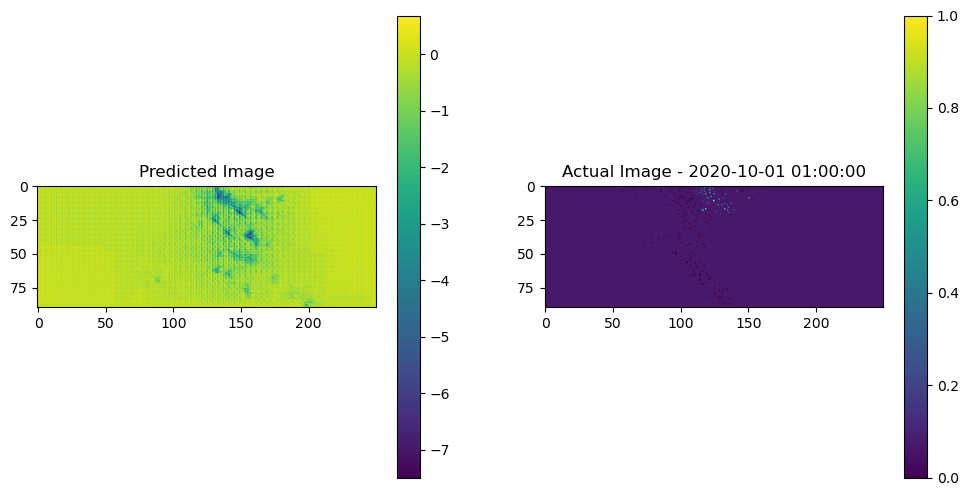

In [27]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load input data
input_file_path = 'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\Radar\\2020\\10\\01\\Radar_20201001000000.tif'

with rasterio.open(input_file_path) as src:
    input_data = src.read(1).astype(np.float32)
    print_stats(input_data, "Input Data")
    input_data = clean_data(input_data)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

input_tensor = transform(input_data)
input_tensor = torch.stack([input_tensor, input_tensor], dim=0)
input_tensor = input_tensor.unsqueeze(0).to(device)

# Load the model
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
# model.load_state_dict(torch.load('D:\\Workspace\\Projects\\qpn-simvp\\simvp\\pth\\last_checkpoint.pth'))
model.eval()

# Predict and visualize
with torch.no_grad():
    prediction = model(input_tensor)

# Checking for non-finite values in predictions
finite_mask = torch.isfinite(prediction)
if not finite_mask.all():
    print("Non-finite values detected in predictions.")
    prediction[~finite_mask] = 0

predicted_image = prediction.squeeze().cpu().numpy()
# print_stats(predicted_image, "Predicted Image")

def compute_metrics(prediction, ground_truth, threshold=0.1):
    # Flatten the arrays to compute metrics
    pred_flat = prediction.flatten()
    gt_flat = ground_truth.flatten()
    
    # Binarize predictions and ground truth based on threshold
    pred_binary = (pred_flat >= threshold).astype(int)
    gt_binary = (gt_flat >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(gt_binary, pred_binary)
    if cm.shape == (2, 2):  # Ensure the confusion matrix is complete
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases where true negatives or positives might be missing
        tn, fp, fn, tp = 0, 0, 0, 0
        if cm.shape == (1, 1):
            if pred_binary[0] == 0 and gt_binary[0] == 0:
                tn = cm[0, 0]
            else:
                tp = cm[0, 0]
    
    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Critical Success Index (CSI)
    csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred_flat - gt_flat) ** 2))
    
    return precision, csi, rmse


print(f'Precision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}')

# Compute metrics
current_datetime = extract_datetime_from_filename(input_file_path)
predicted_datetime = predict_next_datetime(current_datetime)
print("Current datetime from input file:", current_datetime)
print("Predicted datetime for next frame:", predicted_datetime)

# actual_file_path = f'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\Radar\\{predicted_datetime.year}\\{predicted_datetime.month:02d}\\{predicted_datetime.day:02d}\\Radar_{predicted_datetime.strftime("%Y%m%d%H%M%S")}.tif'
actual_file_path = f'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\AWS\\{predicted_datetime.year}\\{predicted_datetime.month:02d}\\{predicted_datetime.day:02d}\\AWS_{predicted_datetime.strftime("%Y%m%d%H%M%S")}.tif'

try:
    with rasterio.open(actual_file_path) as src:
        actual_data = src.read(1).astype(np.float32)
        print_stats(actual_data, "Actual Data")
        actual_data = clean_data(actual_data)
        actual_data = (actual_data - actual_data.min()) / (actual_data.max() - actual_data.min())
    
    mse, psnr, ssim_index = compute_metrics(predicted_image[0], actual_data)
    
    print(f'MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_index:.4f}')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_image[0], cmap='viridis')
    plt.colorbar()
    plt.title("Predicted Image")

    plt.subplot(1, 2, 2)
    plt.imshow(actual_data, cmap='viridis')
    plt.colorbar()
    plt.title(f"Actual Image - {predicted_datetime}")
    plt.show()
except FileNotFoundError:
    print(f"Actual next image file not found: {actual_file_path}")


Precision: 0.0040, CSI: 0.0037, RMSE: 0.6945


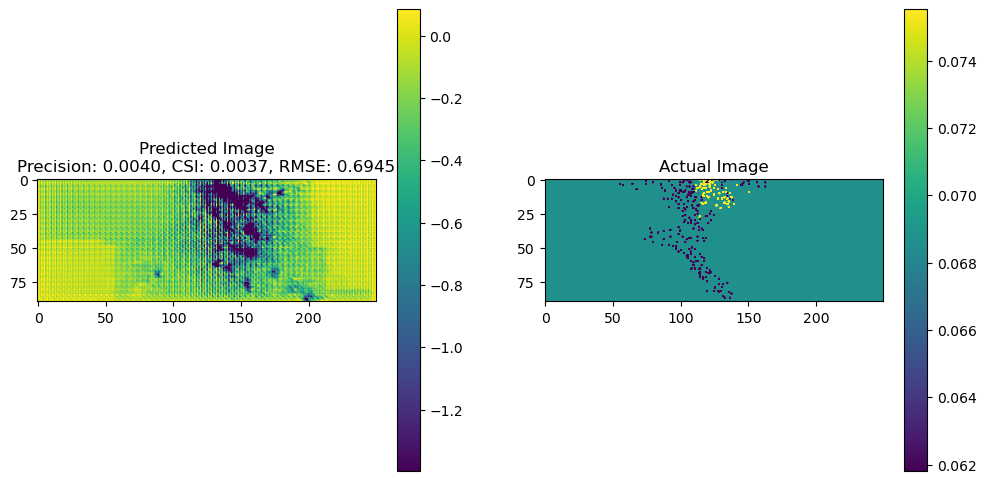

In [28]:
import numpy as np
from sklearn.metrics import precision_score, confusion_matrix

def compute_metrics(prediction, ground_truth, threshold=0.1):
    # Flatten the arrays to compute metrics
    pred_flat = prediction.flatten()
    gt_flat = ground_truth.flatten()
    
    # Binarize predictions and ground truth based on threshold
    pred_binary = (pred_flat >= threshold).astype(int)
    gt_binary = (gt_flat >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(gt_binary, pred_binary)
    if cm.shape == (2, 2):  # Ensure the confusion matrix is complete
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases where true negatives or positives might be missing
        tn, fp, fn, tp = 0, 0, 0, 0
        if cm.shape == (1, 1):
            if pred_binary[0] == 0 and gt_binary[0] == 0:
                tn = cm[0, 0]
            else:
                tp = cm[0, 0]
    
    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Critical Success Index (CSI)
    csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred_flat - gt_flat) ** 2))
    
    return precision, csi, rmse

precision, csi, rmse = compute_metrics(predicted_image[0], actual_data)

print(f'Precision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}')

def get_vmin_vmax(image, lower_pct=5, upper_pct=95):
    return np.percentile(image, lower_pct), np.percentile(image, upper_pct)

predicted_vmin, predicted_vmax = get_vmin_vmax(predicted_image[0])
actual_vmin, actual_vmax = get_vmin_vmax(actual_data)

plt.figure(figsize=(12, 6))

# Adjusting subplot for predicted image
plt.subplot(1, 2, 1)
plt.imshow(predicted_image[0], cmap='viridis', vmin=predicted_vmin, vmax=predicted_vmax)  
plt.colorbar()
plt.title(f"Predicted Image\nPrecision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}")

# Adjusting subplot for actual image
plt.subplot(1, 2, 2)
plt.imshow(actual_data, cmap='viridis', vmin=actual_vmin, vmax=actual_vmax)
plt.colorbar()
plt.title("Actual Image")

plt.show()